In [8]:
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
import dotenv
import pendulum
from sqlalchemy import create_engine, desc
from sqlalchemy.orm import sessionmaker
from config import Settings
from models import MessageSql
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta

settings = Settings(_env_file=dotenv.find_dotenv())
valid_password = settings.thermostat_api_key.get_secret_value()
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)


session = Session()
timezone = "America/New_York"
start = pendulum.datetime(2024, 10, 14, 0, 0, tz=timezone)
end = pendulum.datetime(2024, 10, 16, 10, 0, tz=timezone)
start_ms = int(start.timestamp() * 1000)
end_ms = int(end.timestamp() * 1000)

messages = session.query(MessageSql).filter(
    MessageSql.from_alias.like(f'%oak%'),
    MessageSql.message_persisted_ms >= start_ms,
    MessageSql.message_persisted_ms <= end_ms,
).order_by(desc(MessageSql.message_persisted_ms)).all()

In [9]:
def to_fahrenheit(t):
    return t*9/5+32

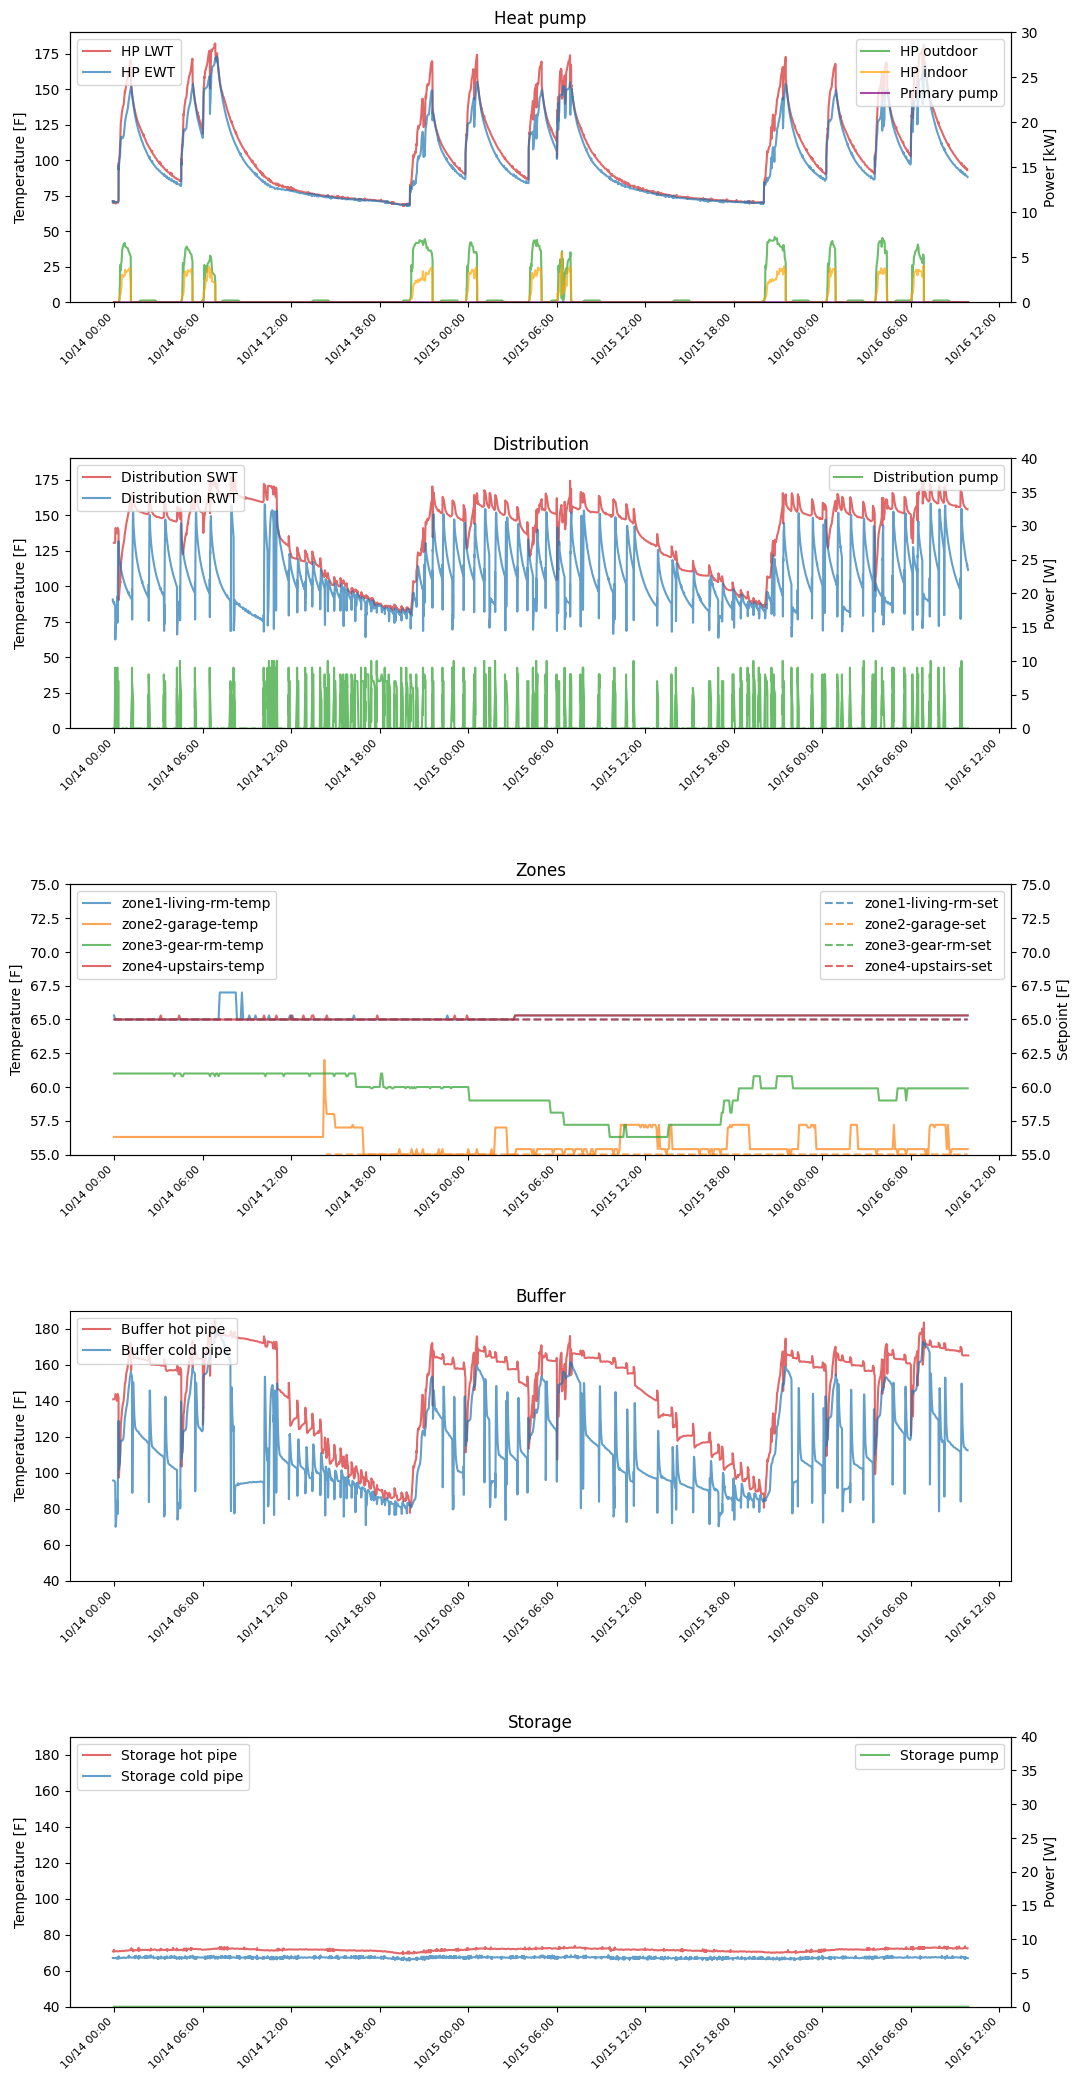

Done in 2.9089548587799072


In [22]:
import time

start_time = time.time()

channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        if channel['ChannelName'] not in channels:
            channels[channel['ChannelName']] = {
                'values': channel['ValueList'],
                'times': channel['ScadaReadTimeUnixMsList']
            }
        else:
            channels[channel['ChannelName']]['values'].extend(channel['ValueList'])
            channels[channel['ChannelName']]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['values'] = list(sorted_values)
    channels[key]['times'] = pd.to_datetime(list(sorted_times), unit='ms', utc=True)
    channels[key]['times'] = channels[key]['times'].tz_convert('America/New_York')
    channels[key]['times'] = [x.replace(tzinfo=None) for x in channels[key]['times']]

fig, ax = plt.subplots(5,1, figsize=(12,22), sharex=True)

# --------------------------------------
# First plot: HP loop
# --------------------------------------

for key in channels.keys():
    if 'hp' in key or 'primary' in key:
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        if 'wt' in key:
            channels[key]['values'] = [to_fahrenheit(x) for x in channels[key]['values']]

ax[0].plot(channels['hp-lwt']['times'], channels['hp-lwt']['values'], color='tab:red', alpha=0.7, label='HP LWT')
ax[0].plot(channels['hp-ewt']['times'], channels['hp-ewt']['values'], color='tab:blue', alpha=0.7, label='HP EWT')
ax[0].set_ylabel('Temperature [F]')
if max(channels['hp-lwt']['values']) < 190:
    ax[0].set_ylim([0,190])
ax[0].legend(loc='upper left')
ax20 = ax[0].twinx()
ax20.plot(channels['hp-odu-pwr']['times'], channels['hp-odu-pwr']['values'], color='tab:green', alpha=0.7, label='HP outdoor')
ax20.plot(channels['hp-idu-pwr']['times'], channels['hp-idu-pwr']['values'], color='orange', alpha=0.7, label='HP indoor')
ax20.plot(channels['primary-pump-pwr']['times'], channels['primary-pump-pwr']['values'], color='purple', alpha=0.7, label='Primary pump')
ax20.set_ylabel('Power [kW]')
if max(channels['hp-odu-pwr']['values']) < 30 and max(channels['hp-idu-pwr']['values']) < 30:
    ax20.set_ylim([0,30])
ax20.legend(loc='upper right')
ax[0].set_title('Heat pump')

# --------------------------------------
# Second plot: distribution loop
# --------------------------------------

for key in channels.keys():
    if 'dist' in key: #or 'zone' in key:
        if 'pump' not in key and 'zone' not in key:
            channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        if 'wt' in key:
            channels[key]['values'] = [to_fahrenheit(x) for x in channels[key]['values']]
        
ax[1].plot(channels['dist-swt']['times'], channels['dist-swt']['values'], color='tab:red', alpha=0.7, label='Distribution SWT')
ax[1].plot(channels['dist-rwt']['times'], channels['dist-rwt']['values'], color='tab:blue', alpha=0.7, label='Distribution RWT')
ax[1].set_ylabel('Temperature [F]')
ax[1].set_ylim([0,190])
ax[1].legend(loc='upper left')
ax21 = ax[1].twinx()
ax21.plot(channels['dist-pump-pwr']['times'], channels['dist-pump-pwr']['values'], color='tab:green', alpha=0.7, label='Distribution pump')
ax21.set_ylabel('Power [W]')
ax21.set_ylim([0,40])
ax21.legend(loc='upper right')
ax[1].set_title('Distribution')

# --------------------------------------
# Third plot: zones
# --------------------------------------

zones = {}
for key in channels.keys():
    if 'zone' in key:
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        if key.split('-')[0] not in zones:
            zones[key.split('-')[0]] = [key]
        else:
            zones[key.split('-')[0]].append(key)
    
ax22 = ax[2].twinx()
colors = {}
for zone in zones:
    for temp in zones[zone]:
        if 'temp' in temp:
            color = ax[2].plot(channels[temp]['times'], channels[temp]['values'], label=temp, alpha=0.7)[0].get_color()
            colors[temp] = color
        elif 'set' in temp:
            base_temp = temp.replace('-set', '-temp')
            if base_temp in colors:
                ax22.plot(channels[temp]['times'], channels[temp]['values'], label=temp, 
                         linestyle='dashed', color=colors[base_temp], alpha=0.7)
ax[2].set_ylabel('Temperature [F]')
ax22.set_ylabel('Setpoint [F]')
ax[2].set_ylim([55, 75])
ax22.set_ylim([55, 75])
ax[2].legend(loc='upper left')
ax22.legend(loc='upper right')
ax[2].set_title('Zones')

# --------------------------------------
# Fourth plot: buffer
# --------------------------------------

for key in channels.keys():
    if 'buffer' in key:
        if 'pipe' in key:
            channels[key]['values'] = [to_fahrenheit(x/1000) for x in channels[key]['values']]
        else:
            channels[key]['values'] = [x/1000 for x in channels[key]['values']]

ax[3].plot(channels['buffer-hot-pipe']['times'], channels['buffer-hot-pipe']['values'], 
           color='tab:red', alpha=0.7, label='Buffer hot pipe')
ax[3].plot(channels['buffer-cold-pipe']['times'], channels['buffer-cold-pipe']['values'], 
           color='tab:blue', alpha=0.7, label='Buffer cold pipe')
ax[3].set_ylabel('Temperature [F]')
ax[3].set_ylim([40,190])
ax[3].legend(loc='upper left')
ax[3].set_title('Buffer')

# --------------------------------------
# Fifth plot: storage
# --------------------------------------

for key in channels.keys():
    if 'store' in key:
        if 'pipe' in key:
            channels[key]['values'] = [to_fahrenheit(x/1000) for x in channels[key]['values']]
        else:
            channels[key]['values'] = [x/1000 for x in channels[key]['values']]

ax[4].plot(channels['store-hot-pipe']['times'], channels['store-hot-pipe']['values'], 
           color='tab:red', alpha=0.7, label='Storage hot pipe')
ax[4].plot(channels['store-cold-pipe']['times'], channels['store-cold-pipe']['values'], 
           color='tab:blue', alpha=0.7, label='Storage cold pipe')
ax[4].set_ylabel('Temperature [F]')
ax[4].set_ylim([40,190])
ax[4].legend(loc='upper left')
ax24 = ax[4].twinx()
ax24.plot(channels['store-pump-pwr']['times'], channels['store-pump-pwr']['values'], 
          color='tab:green', alpha=0.7, label='Storage pump')
ax24.set_ylabel('Power [W]')
ax24.set_ylim([0,40])
ax24.legend(loc='upper right')
ax[4].set_title('Storage')

for axis in ax:
    xlim = axis.get_xlim()
    if (mdates.num2date(xlim[1]) - mdates.num2date(xlim[0]) >= timedelta(hours=4) and 
        mdates.num2date(xlim[1]) - mdates.num2date(xlim[0]) <= timedelta(hours=30)):
        axis.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    elif (mdates.num2date(xlim[1]) - mdates.num2date(xlim[0]) >= timedelta(hours=31) and 
        mdates.num2date(xlim[1]) - mdates.num2date(xlim[0]) <= timedelta(hours=65)):
        axis.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    axis.tick_params(axis='x', which='both', labelbottom=True, labelsize=8)
    plt.setp(axis.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout(pad=5.0)
plt.show()

# # plt.show()
# img_buf = io.BytesIO()
# plt.savefig(img_buf, format='png')
# img_buf.seek(0)  # Move to the beginning of the BytesIO object

# # Write the image to the zip file
# zip_file.writestr(f'{plot_type}_plot.png', img_buf.getvalue())
# plt.close()

print(f'Done in {time.time()-start_time}')